In [1]:
import os
import sys
import warnings
import math

sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import geopandas as gpd
import pandas as pd
import networkx as nx
import shapely.geometry
from shapely.geometry import Polygon as Poly, Point
from shapely.geometry import MultiPolygon as MultiPoly
from shapely.affinity import scale
from shapely.ops import unary_union
import shapely.wkt as swkt
import ogr
import time
from scipy.spatial import Voronoi

from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.cg import cg

from unittest.mock import Mock
from unittest.mock import MagicMock
from autocnet.graph import edge
from autocnet.graph import node
from autocnet.graph.node import Node
from autocnet.transformation import homography as hm
from plio.io import io_gdal

from autocnet.utils.utils import array_to_poly

from IPython.display import display

%pylab inline
figsize(20, 20)

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Pragma No Cover
def compute_cliques(graph, node_id=None):
    if node_id is not None:
        return list(nx.cliques_containing_node(graph, nodes=node_id))
    else:
        return list(nx.find_cliques(graph))

In [4]:
def compute_vor_weight(vor, intersection, geometry=False):
    if geometry:
        voronoi_df = gpd.GeoDataFrame(data = keypoints, columns = ['x', 'y', 'weight', 'geometry'])
    else:
        voronoi_df = gpd.GeoDataFrame(data = keypoints, columns = ['x', 'y', 'weight'])

    
    vor_polys = []

    i = 0
    vor_points = np.asarray(vor.points)
    for region in vor.regions:
        region_point = vor_points[np.argwhere(vor.point_region==i)]
        
        if not -1 in region:
            polygon_points = [vor.vertices[i] for i in region]
            
            if len(polygon_points) != 0:
                polygon = Poly(polygon_points)
                
                if intersection is not None:
                    intersection_poly = polygon.intersection(intersection)
                else:
                    intersection_poly = polygon.intersection(min_bounding_box)
                
                voronoi_df.loc[(voronoi_df["x"] == region_point[0][0][0]) & 
                               (voronoi_df["y"] == region_point[0][0][1]), 
                               'weight'] = intersection_poly.area
                if geometry:
                    voronoi_df.loc[(voronoi_df["x"] == region_point[0][0][0]) & 
                                   (voronoi_df["y"] == region_point[0][0][1]), 
                                   'geometry'] = intersection_poly
        i+=1
    
    return voronoi_df

In [5]:
def compute_voronoi(keypoints, intersection=None, geometry=False, s=30):
    vor_keypoints = []
        
    keypoints.apply(lambda x: vor_keypoints.append((x['x'], x['y'])), axis = 1)
    
    if intersection is None:
        keypoint_bounds = Poly(vor_keypoints).bounds
        intersection = shapely.geometry.box(keypoint_bounds[0], keypoint_bounds[1], 
                                            keypoint_bounds[2], keypoint_bounds[3])

    scaled_coords = np.array(scale(intersection, s, s).exterior.coords)
        
    vor_keypoints = np.vstack((vor_keypoints, scaled_coords))
    vor = Voronoi(vor_keypoints)

    # For weight computation
    # Should move to its own method
    if geometry:
        voronoi_df = gpd.GeoDataFrame(data = keypoints, columns = ['x', 'y', 'weight', 'geometry'])
    else:
        voronoi_df = gpd.GeoDataFrame(data = keypoints, columns = ['x', 'y', 'weight'])

    
    vor_polys = []

    i = 0
    vor_points = np.asarray(vor.points)
    for region in vor.regions:
        region_point = vor_points[np.argwhere(vor.point_region==i)]
        
        if not -1 in region:
            polygon_points = [vor.vertices[i] for i in region]
            
            if len(polygon_points) != 0:
                polygon = Poly(polygon_points)
                
                if intersection is not None:
                    intersection_poly = polygon.intersection(intersection)
                else:
                    intersection_poly = polygon.intersection(min_bounding_box)
                
                voronoi_df.loc[(voronoi_df["x"] == region_point[0][0][0]) & 
                               (voronoi_df["y"] == region_point[0][0][1]), 
                               'weight'] = intersection_poly.area
                if geometry:
                    voronoi_df.loc[(voronoi_df["x"] == region_point[0][0][0]) & 
                                   (voronoi_df["y"] == region_point[0][0][1]), 
                                   'geometry'] = intersection_poly
        i+=1
    
    return voronoi_df

In [6]:
#------TEST-------
keypoints = pd.DataFrame({'x': (15, 18, 18, 12, 12), 'y': (6, 10, 15, 15, 10)})

intersection = Poly([(10, 5), (20, 5), (20, 20), (10, 20)])
voronoi_gdf = compute_voronoi(keypoints)
# ax = voronoi_gdf.plot()
print(voronoi_gdf.weight)

voronoi_inter_gdf = compute_voronoi(keypoints, intersection)
# voronoi_inter_gdf.plot(ax = ax)
print(voronoi_inter_gdf.weight)

0    12.0
1    13.5
2     7.5
3     7.5
4    13.5
Name: weight, dtype: float64
0    22.50
1    26.25
2    37.50
3    37.50
4    26.25
Name: weight, dtype: float64


In [17]:
'''
Computes the intercetion of all images in a graph
based around a given source node
'''
def compute_intersection(graph, source, clean_keys=[], ax = None):
    if type(source) is int:
        source = graph.node[source]
        
    try:
        source_poly = swkt.loads(source.geodata.footprint.GetGeometryRef(0).ExportToWkt())
    except:
        raise AttributeError()
    
    source_gdf = gpd.GeoDataFrame({'geometry': [source_poly], 'source_node': [source['node_id']]})
    
    proj_gdf = gpd.GeoDataFrame(columns = ['geometry', 'proj_node'])
    
    # Begin iterating through the edges in the graph excluding the source node
    for s, d, edge in graph.edges_iter(data=True):
        if s == source['node_id']:
            proj_poly = swkt.loads(edge.destination.geodata.footprint.GetGeometryRef(0).ExportToWkt())
        elif d == source['node_id']:
            proj_poly = swkt.loads(edge.source.geodata.footprint.GetGeometryRef(0).ExportToWkt())
        else:
            continue
            
        proj_gdf.loc[len(proj_gdf)] = [proj_poly, n]
    
    intersect_gdf = gpd.overlay(source_gdf, proj_gdf, how='intersection')
    intersect_gdf['overlaps_all'] = intersect_gdf.geometry.apply(lambda x:proj_gdf.geometry.contains(scale(x, .9, .9)).all())
    
    if len(intersect_gdf.query("overlaps_all == True")) <= 0:
        new_poly = unary_union(intersect_gdf.geometry)
        intersect_gdf.loc[len(intersect_gdf)] = [source['node_id'], source['node_id'], new_poly, True]
    
    ax = intersect_gdf.query("overlaps_all == True").plot(color = 'r')
    source_gdf.plot(ax = ax, color = 'b', alpha = .1)
    proj_gdf.plot(ax = ax, color = 'b', alpha = .1)
    
    return intersect_gdf

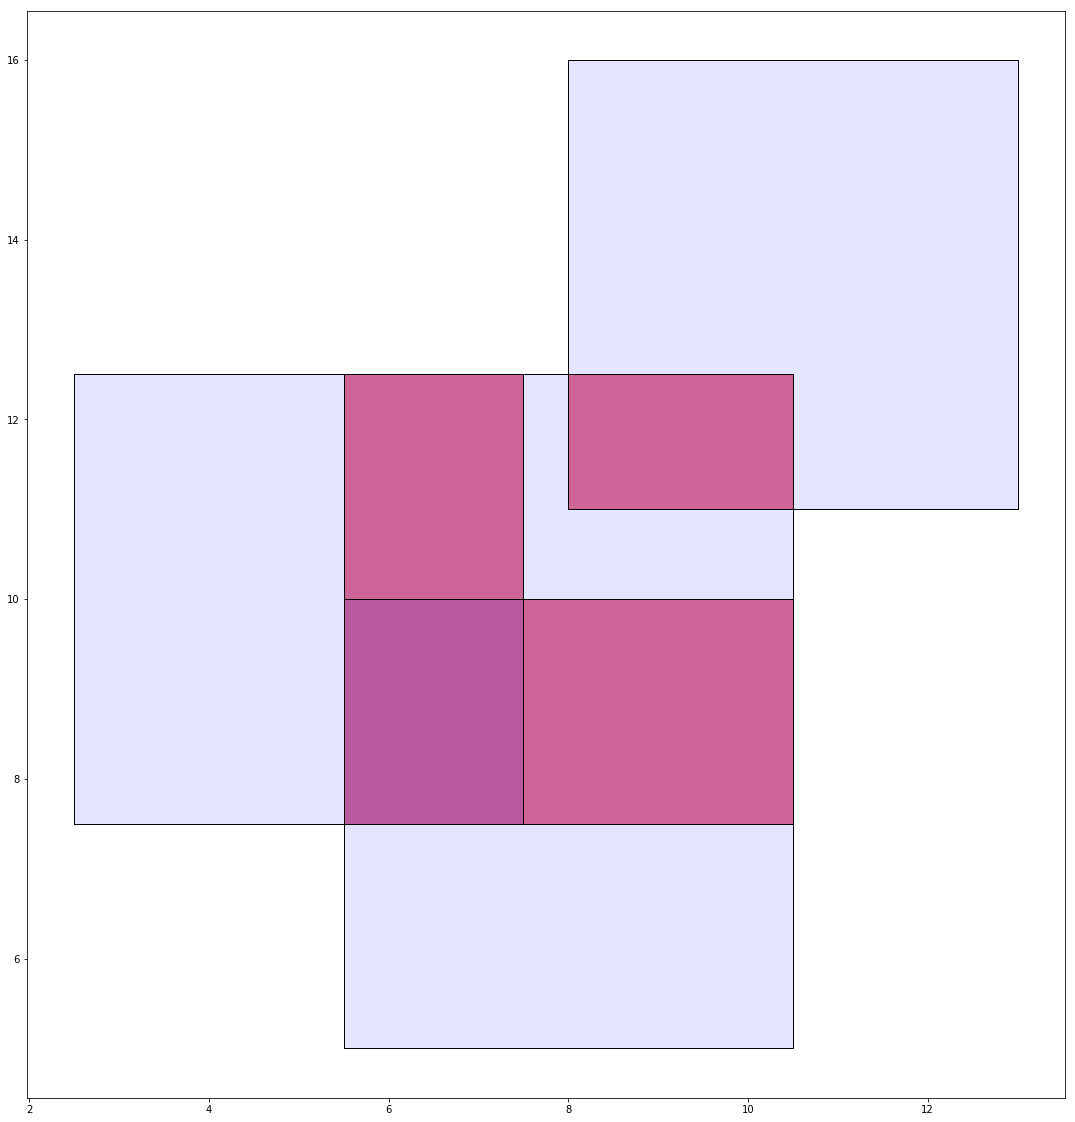

In [18]:
#------TEST-------
# Generate the footprints for the mock nodes
ogr_poly_list = []
wkt0 = "MULTIPOLYGON (((2.5 7.5,7.5 7.5,7.5 12.5,2.5 12.5,2.5 7.5)))"
ogr_poly_list.append(ogr.CreateGeometryFromWkt(wkt0))
wkt1 = "MULTIPOLYGON (((0 10, 5 10, 5 15, 0 15, 0 10)))"
ogr_poly_list.append(ogr.CreateGeometryFromWkt(wkt1))
wkt2 = "MULTIPOLYGON (((5.5 5.0,10.5 5.0,10.5 10.0,5.5 10.0,5.5 5.0)))"
ogr_poly_list.append(ogr.CreateGeometryFromWkt(wkt2))
wkt3 = "MULTIPOLYGON (((5.5 7.5,10.5 7.5,10.5 12.5,5.5 12.5,5.5 7.5)))"
ogr_poly_list.append(ogr.CreateGeometryFromWkt(wkt3))
wkt4 = "MULTIPOLYGON (((8 11,13 11,13 16,8 16,8 11)))"
ogr_poly_list.append(ogr.CreateGeometryFromWkt(wkt4))
wkt5 = "MULTIPOLYGON (((8 14,13 14,13 19,8 19,8 14)))"
ogr_poly_list.append(ogr.CreateGeometryFromWkt(wkt5))
wkt6 = "MULTIPOLYGON (((11 11,16 11,16 16,11 16,11 11)))"
ogr_poly_list.append(ogr.CreateGeometryFromWkt(wkt6))
wkt7 = "MULTIPOLYGON (((11 14,16 14,16 19,11 19,11 14)))"
ogr_poly_list.append(ogr.CreateGeometryFromWkt(wkt7))

# Create the graph and all the mocked nodes
cang = CandidateGraph()
for n in range(0, 8):
    cang.add_node(n)
    new_node = MagicMock(spec = Node())
    geodata = MagicMock(spec = io_gdal.GeoDataset)
    new_node.geodata = geodata
    geodata.footprint = ogr_poly_list[n]
    new_node.__getitem__ = MagicMock(return_value=(n))
    cang.node[n] = new_node

# Create the edges between the nodes in the graph
cang.add_edge(0, 1)    
cang.add_edge(0, 2)
cang.add_edge(0, 3)
cang.add_edge(2, 3)
cang.add_edge(3, 4)
cang.add_edge(4, 5)
cang.add_edge(5, 6)
cang.add_edge(6, 7)
cang.add_edge(7, 4)
cang.add_edge(4, 6)
cang.add_edge(5, 7)

# Define source and destination for each edge
for s, d in cang.edges():
    if s > d:
        s, d = d, s
    e = cang.edge[s][d]
    e.source = cang.node[s]
    e.destination = cang.node[d]


# Perform intersection calculations on cliques and then the graph as a whole given a source
# cliques = compute_cliques(cang)
# for g in cliques:
#     subgraph = cang.create_node_subgraph(g)
#     for n in g:
#         intersect_gdf = compute_intersection(n, subgraph)
#         print(intersect_gdf)
# subgraph = cang.create_node_subgraph([0, 1, 2, 3, 4, 5, 6, 7])
intersect_gdf = compute_intersection(cang, 3)

In [9]:
def geom_mask(kps, geom):
    # Initial bounding box query to reduce the problem size
    def _in_mbr(r, mbr):
        if (mbr[0] <= r.x <= mbr[2]) and (mbr[1] <= r.y <= mbr[3]):
            return True
        else:
            return False
        
    mbr = geom.bounds
    initial_mask = kps.apply(_in_mbr, axis=1, args=(mbr,))

    return initial_mask

In [10]:
def reproject_geom(node, coords):
    reproj = []
    for x, y in coords:
        reproj.append(node.geodata.latlon_to_pixel(x,y))
        
    return Poly(reproj)

In [11]:
def compute_weights(graph, clean_keys=[], **kwargs):
    neighbors_dict = nx.degree(graph)
    if False in list(all(value == len(graph.neighbors(graph.nodes()[0])) for value in neighbors_dict.values())):
        warnings.warn('The given graph is not complete and may yield garbage.')
        
    source_node = graph.nodes(data=True)[0][1]
    
    # Have compute_intersection get the intersections of the subgraph, the projected nodes in the
    # subgraph, and the source image all in there own geopandas dataframes
    intersect_gdf = compute_intersection(graph, source_node, clean_keys)
    
    for s, d, edge in graph.edges_iter(data=True):
        # Recompute the intersection if the source node of the n + 1 edge is different from the n edge
        if s != source_node['node_id']:
            source_node = edge.source
            intersect_gdf = compute_intersection(graph, source_node, clean_keys)
        
        kps = edge.get_keypoints('source', clean_keys = clean_keys)[['x', 'y']]
        
        reproj_geom = reproject_geom(source_node, intersect_gdf.query("overlaps_all == True").geometry.values[0].__geo_interface__['coordinates'][0])
        
        initial_mask = geom_mask(kps, reproj_geom)
        
        if (len(kps[initial_mask]) <= 0):
            continue
        
        kps['geometry'] = kps.apply(lambda x: Point(x['x'], x['y']), axis = 1)
        
        kps_mask = kps['geometry'][initial_mask].apply(lambda x: reproj_geom.contains(x))

        voronoi_df = compute_voronoi(kps[initial_mask][kps_mask], reproj_geom, geometry=True)
        
        # plot the intersection as well as the source and projected images
        intersect_gdf.query('overlaps_all == True').plot(color = 'b')
        
        ax = voronoi_df.plot()
        edge.plot_source(ax = ax, clean_keys = clean_keys, color = 'r', s=60, marker='o')
    
        edge['weights']['vor_weight'] = voronoi_df['weight']

In [23]:
#Point to the adjacency Graph
adjacency = get_path('user_adjacency.json')
basepath = get_path('Apollo15')
cang = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cang.extract_features(method='sift', extractor_parameters={'nfeatures':900})

#Match
cang.match()

#Apply outlier detection
# cg.apply_func_to_edges(Edge.symmetry_check)
cang.symmetry_checks()
# cg.apply_func_to_edges(Edge.ratio_check)
cang.ratio_checks(clean_keys = ['symmetry'])


#Compute a homography and apply RANSAC
cang.compute_fundamental_matrices(clean_keys = ['symmetry', 'ratio'])

/home/acpaquette/autocnet/autocnet/transformation/fundamental_matrix.py:252: UserWarning: Unable to apply MLE.  Not enough correspondences.  Returning with a RANSAC computed F matrix.
  warnings.warn("Unable to apply MLE.  Not enough correspondences.  Returning with a RANSAC computed F matrix.")


[[0, 1, 2]]


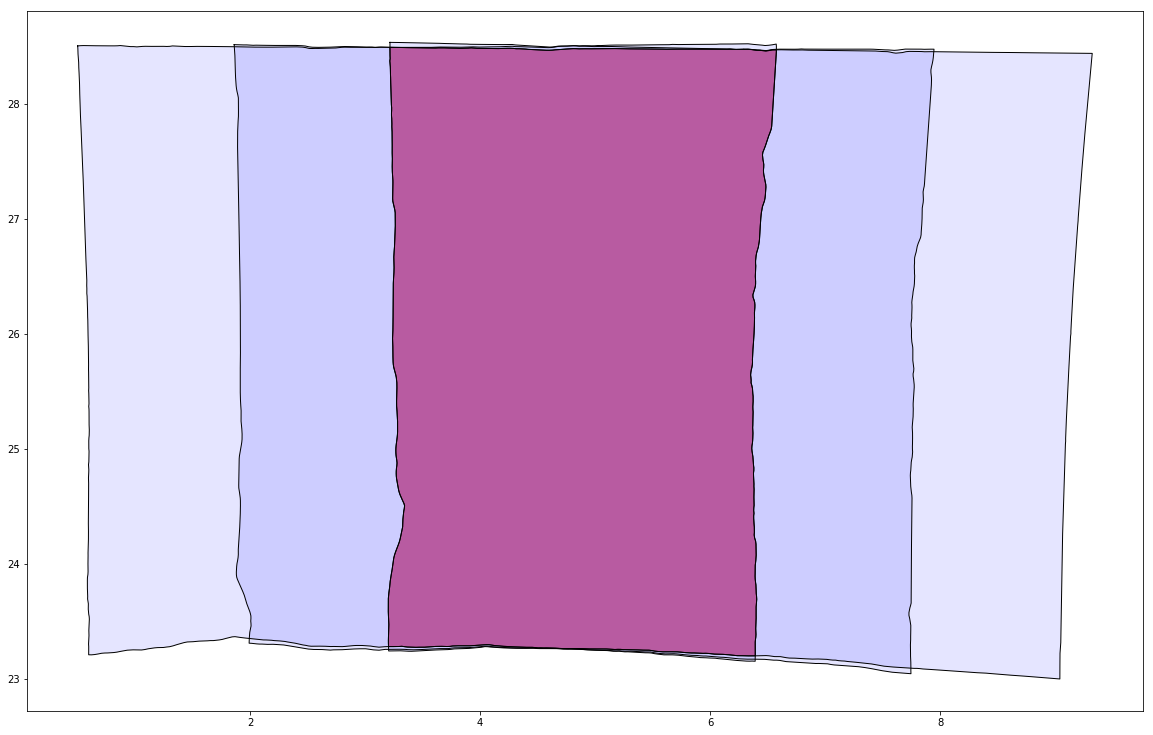

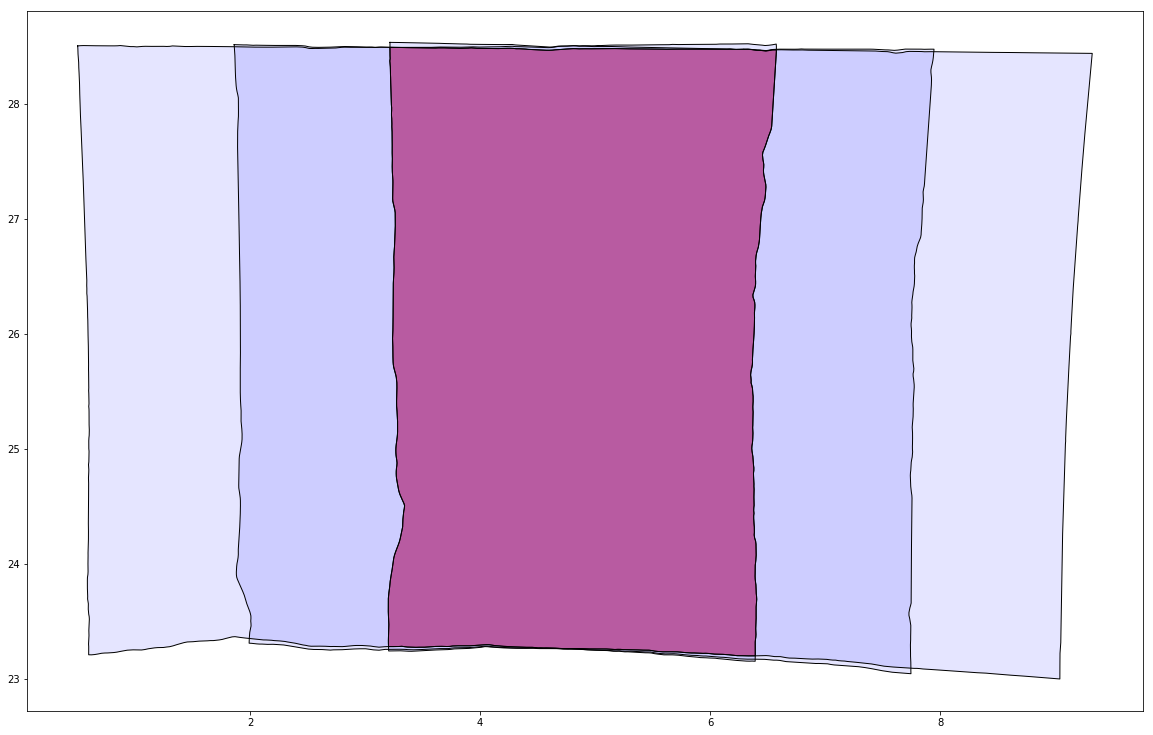

In [24]:
# start = time.clock()
cliques = compute_cliques(cang, node_id = None)
print(cliques)

for g in cliques:
    subgraph = cang.create_node_subgraph(g)
    compute_weights(cang, clean_keys=['symmetry', 'ratio', 'fundamental'])

# compute_weights(cang, clean_keys = ['fundamental'])

In [ ]:
def vor_plot(graph, clean_keys = []):
    
    num_neighbors = len(graph.nodes()) - 1
    for n in graph.nodes():
        neighbors = len(graph.neighbors(n))
        if neighbors != num_neighbors:
            raise AssertionError('The graph is not complete')
    
    intersection, proj_gdf, source_gdf = compute_intersection(graph.nodes()[0], graph, clean_keys)
    
    source_node = graph.nodes()[0]

    for e in graph.edges():
        if e[0] != source_node:
            source_node = e[0]
            start_inter = time.clock()
            intersection, proj_gdf, source_gdf = compute_intersection(source_node, graph, clean_keys)
            
        edge = graph.edge[e[0]][e[1]]
        kps = edge.get_keypoints('source', clean_keys = clean_keys, homogeneous = True)
        kps = kps[edge.vor_mask]
        
        vor = edge.voronoi
    
        i = 0
        poly_array = []
        vor_points = np.asarray(vor.points)
        for region in vor.regions:
            region_point = vor_points[np.argwhere(vor.point_region==i)]
            if not -1 in region:
                polygon_points = [vor.vertices[i] for i in region]
                if len(polygon_points) != 0:
                    polygon = Poly(polygon_points)
                    poly_array.append(polygon)
            i+=1
            
        poly_gdf = gpd.GeoDataFrame(data = poly_array, columns = ['geometry'])
        vor_poly_gdf = gpd.overlay(poly_gdf, intersection, how='intersection')
        
        ax = proj_gdf.query('proj_node != ' + str(n)).plot(color='#388aff', alpha=0.1)
        proj_gdf.query('proj_node == ' + str(n)).plot(color = 'g', alpha=0.1, ax = ax)
        source_gdf.plot(color='r', alpha=0.1, ax=ax)
        vor_poly_gdf.plot(cmap='Set1', alpha=.5, ax=ax)
#             graph.edge[0][3].plot(clean_keys = ['fundamental'], ax = ax)
        edge.source.plot(index_mask = edge.matches['destination_idx'], alpha = 0)
        matplotlib.pyplot.scatter(kps['x'], kps['y'], color = 'black', alpha = 1)